In [1]:
%load_ext autoreload

%autoreload 2
import matplotlib.pyplot as plt
import pickle
from astropy.coordinates import SkyCoord, match_coordinates_3d, match_coordinates_sky
import sys
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.table import Table, QTable, hstack, vstack
from astropy import units as u
from astropy.coordinates import SkyCoord, match_coordinates_3d
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
import iminuit
import emcee
from iminuit import Minuit
cosmo_astropy.critical_density(0.4).to(u.Msun / u.Mpc**3).value
import corner
#sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis')
#import corner
#import make_profile as prf

sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/')
import CL_WL_miscentering as mis
import CL_WL_DATAOPS_make_profile as prf
import CL_WL_two_halo_term as twoh
import CL_WL_mass_conversion as utils
import CL_WL_fit_cluster_mass as fit
import CL_Mass_richness_relation as mr

sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/DESC_note/Notebooks/')
import analysis_Mass_observable_relation as analysis

import clmm
import clmm.dataops
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
import astropy.units as un
from clmm import Cosmology
from clmm.support import mock_data as mock
import pyccl as ccl
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_ccl  = ccl.Cosmology(Omega_c=0.265-0.0448, Omega_b=0.0448, h=0.71, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)

In [2]:
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

In [3]:
profile_Metacal = load('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/p_RedMapper_clusters/paper_dc2_galaxy_cluster_mass/data_DS/DC2_object/individual_Metacal_shape_BPZ_z_all_bins.pkl')
profile_HSM = load('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/p_RedMapper_clusters/paper_dc2_galaxy_cluster_mass/data_DS/DC2_object/individual_HSM_epsilon_shape_BPZ_z_all_bins.pkl')
profile_true = load('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/p_RedMapper_clusters/paper_dc2_galaxy_cluster_mass/data_DS/Richness_cosmodc2_flex_BPZ/individual_epsilon_shape_true_z_all_bins.pkl')

In [4]:
%load_ext autoreload
%autoreload 2
sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/DESC_note/Notebooks/')
import DN1_binned_mass_richness_relation as fiducial
fiducial_constraint = fiducial.constrain_fiducial(used_cluster_id_list = np.array(profile_true['cluster_id']), low_M_cut = 3e13)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 100/100 [00:12<00:00,  7.74it/s]


In [5]:
gt_av = profile_Metacal['gt_av']
R_T = profile_Metacal['<R_T>']
a_calib = []
for i, gt in enumerate(gt_av):
    R = R_T[i]
    norm = profile_Metacal['norm_sum'][i]
    a_calib.append(np.array([gt[j]/R[j] if norm[j] != 0 else 0 for j in range(len(gt))]))
profile_Metacal['gt_av_calib'] = np.array(a_calib)
profile_HSM['gt_av_calib'] = profile_HSM['gt_av']/.8

In [6]:
Obs_bin = analysis.Obs_bin
Z_bin = analysis.Z_bin

# WL masses

Metacal

In [7]:
profile_Metacal_stack_calib = prf.stacked_profile(profile = profile_Metacal,
                    r_in = 'radius_av',
                    gt_in = 'gt_av_calib', gx_in = 'gt_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    z_name = 'cluster_z', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)

covariance_Metacal_stack_calib = prf.sample_covariance(profile = profile_Metacal,
                    r_in = 'radius_av',
                    gt_in = 'gt_av_calib', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    #n_boot = 400,
                    z_name = 'cluster_z', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/numpy/ma/core.py:2832: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  order=order, subok=True, ndmin=ndmin)


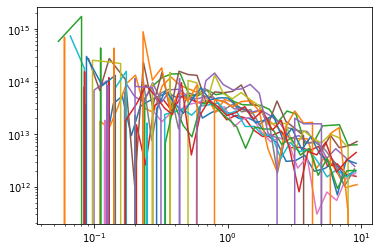

In [8]:
for p in profile_Metacal_stack_calib:
    plt.loglog(p['radius'], p['gt'])

In [9]:
profile_Metacal_stack = prf.stacked_profile(profile = profile_Metacal,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gt_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    z_name = 'cluster_z', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)

covariance_Metacal_stack = prf.sample_covariance(profile = profile_Metacal,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    #n_boot = 400,
                    z_name = 'cluster_z', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/numpy/ma/core.py:2832: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  order=order, subok=True, ndmin=ndmin)


HSM

In [10]:
profile_HSM_stack = prf.stacked_profile(profile = profile_HSM,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gt_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    z_name = 'cluster_z', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)

covariance_HSM_stack = prf.sample_covariance(profile = profile_HSM,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    #n_boot = 400,
                    z_name = 'cluster_z', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)

In [11]:
profile_HSM_stack_calib = prf.stacked_profile(profile = profile_HSM,
                    r_in = 'radius_av',
                    gt_in = 'gt_av_calib', gx_in = 'gt_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    z_name = 'cluster_z', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)

covariance_HSM_stack_calib = prf.sample_covariance(profile = profile_HSM,
                    r_in = 'radius_av',
                    gt_in = 'gt_av_calib', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    #n_boot = 400,
                    z_name = 'cluster_z', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)

True

In [12]:
profile_true_stack = prf.stacked_profile(profile = profile_true,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gt_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    z_name = 'cluster_z', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)

covariance_true_stack = prf.sample_covariance(profile = profile_true,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                #n_boot = 400,
                    z_name = 'cluster_z', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)

In [13]:
a = 1.53 + 0.25
b = 0.38 + 0.10
fit_Metacal = fit.fit_WL_cluster_mass(profile = profile_Metacal_stack, covariance = covariance_Metacal_stack, a = a, b = b, rmax = 5.5, two_halo_term = False, fix_c = True)
fit_Metacal_calib = fit.fit_WL_cluster_mass(profile = profile_Metacal_stack_calib, covariance = covariance_Metacal_stack_calib, a = a, b = b, rmax = 5.5, two_halo_term = False, fix_c = True)
fit_HSM = fit.fit_WL_cluster_mass(profile = profile_HSM_stack, covariance = covariance_HSM_stack, a = a, b = b,rmax = 5.5, two_halo_term = False, fix_c = True)
fit_HSM_calib = fit.fit_WL_cluster_mass(profile = profile_HSM_stack_calib, covariance = covariance_HSM_stack_calib, a = a, b = b,rmax = 5.5, two_halo_term = False, fix_c = True)
fit_true = fit.fit_WL_cluster_mass(profile = profile_true_stack, covariance = covariance_true_stack, a = a, b = b, rmax = 5.5, two_halo_term = False, fix_c = True)

# Mass richness relation

In [14]:
def lnL(theta, m200c_mean, m200c_err_mean, richness_mean, z_mean):
    return mr.lnL_WL_binned(theta, m200c_mean, m200c_err_mean, richness_mean, z_mean, analysis.z0, analysis.richness0)

In [15]:
fits = [fit_Metacal, fit_Metacal_calib, fit_HSM, fit_HSM_calib, fit_true]

In [16]:
z0 = np.median(fits[0]['z_mean'])
richness0 = np.median(fits[0]['obs_mean'])
initial_binned = [14.1,-0,.75]
npath = 100
ndim=3
nwalkers = 800
pos_binned = initial_binned + 0.01 * np.random.randn(nwalkers, len(initial_binned))
label = ['metacal', 'metacal_calib','HSM','HSM_calib', 'true']
sampler_list = {name : 0 for name in label}
for i,fit_true in enumerate(fits):
    m200c_mean = 10**np.array(fit_true['logm200_w'])
    m200c_err_mean =np.array(fit_true['logm200_w_err'])*np.log(10)*m200c_mean
    richness_mean = np.array(fit_true['obs_mean'])
    z_mean = np.array(fit_true['z_mean'])
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnL, args = (m200c_mean, m200c_err_mean, richness_mean, z_mean))
    sampler.run_mcmc(pos_binned, npath,progress=True)
    sampler_wl = sampler.get_chain(discard = 0, flat = True)
    sampler_list[label[i]] = sampler_wl

100%|██████████| 100/100 [00:04<00:00, 22.53it/s]


In [21]:
label_plot = [ r'WL true shapes',r'WL HSM',r'WL HSM calibrated',r'WL Metacalibration',r'WL Metacal']
sampler_tot = [ sampler_list['true'], sampler_list['HSM'],sampler_list['HSM_calib'], sampler_list['metacal'], sampler_list['metacal_calib']]

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


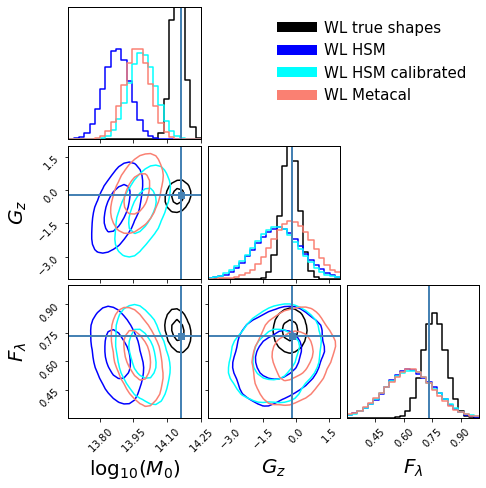

In [22]:
plt.rcParams['axes.linewidth'] = 1.
sigma1 = 1. - np.exp(-(1./1.)**2/2.)
sigma2 = 1. - np.exp(-(2./1.)**2/2.)
sigma3 = 1. - np.exp(-(3./1.)**2/2.)
truth = [14.162, -0.23, 0.8]
bins = 25
labels = [r'$\log_{10}(M_{0})$', r'$G_z$',r'$F_\lambda$']
c = ['k','b','cyan','r','salmon']
fill_contours = [False, False, False,False,  False]
show = [True, True, True, False, True]
fig, axs = plt.subplots(len(labels), len(labels), figsize = (7,7))
for i, name in enumerate(label_plot):
    if show[i] == False: continue
    axs[0,2].plot([],[], c[i], linewidth = 10, label = label_plot[i])

for i,sample in enumerate(sampler_tot):
    if show[i] == False: continue
    a = len(sample)
    sample_cut = sample[50000:a-1]
    fig = corner.corner(
    sample_cut,
    bins=bins, levels=(sigma1, sigma2),
    range = [(13.66, 14.25), (-4, 2),(0.3, 1), ],
    fig = fig,
    color = c[i],
         truths = fiducial_constraint,
    smooth1d=True,smooth=True,plot_datapoints=False,
    fill_contours=fill_contours[i], labels = labels,            
    label_kwargs={"fontsize": 20},
    use_math_text=True,
    show_title = True,
    plot_density=False,
    max_n_ticks = 5);
    
for i in range(len(labels)):
    for j in range(len(labels)):
        axs[i,j].tick_params(axis='both', which = 'major', labelsize= 10)
        axs[i,j].legend(frameon = False, fontsize = 15)
        if i == j:
            axs[i,j].set_ylim(0,7000)

plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/shape.png', bbox_inches='tight', dpi=300)